# INFO-555 Project3
## Kiwoon Hong

## Import Libraries

In [ ]:
pip install openai datasets ipywidgets

In [ ]:
pip install --upgrade --quiet langchain-exa

In [1]:
import pandas as pd
from datasets import load_dataset
from openai import OpenAI
from exa_py import Exa
from langchain_core.tools import tool
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

## Load Data

In [2]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://huggingface.co/datasets/GonzaloA/fake_news?library=pandas)
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["train"])
### END OF CODE FROM EXTERNAL SOURCE (https://huggingface.co/datasets/GonzaloA/fake_news?library=pandas)
df_val = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/GonzaloA/fake_news/" + splits["test"])

## EDA

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,Maury is perhaps one of the trashiest shows on...,0
1,1,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",0
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,"House Majority Whip Steve Scalise (R., La.) th...",0
4,4,Trump Will HATE What Stephen Colbert Just Did...,It can be said that Late Show host Stephen Col...,0


In [4]:
df['label'].value_counts()

label
1    13195
0    11158
Name: count, dtype: int64

In [5]:
df.info()
print()
df_val.info()
print()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24353 non-null  int64 
 1   title       24353 non-null  object
 2   text        24353 non-null  object
 3   label       24353 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 761.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 

## Sampling

In [6]:
sampled_df = df.sample(500, random_state = 97).reset_index(drop = True)

In [7]:
sampled_df.head()

,Unnamed: 0,title,text,label
0,8215,REPORT: Chaos Reigns Inside The White House A...,Donald Trump can t handle the complexity of ru...,0
1,4034,Exclusive: U.S. to renew most Myanmar sanction...,WASHINGTON (Reuters) - The United States plans...,1
2,3011,Anti-Trump Protester Surrounded By Mexican Fla...,It was actually refreshing to see the cops fig...,0
3,2151,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,1
4,5588,Fight over electoral district boundaries heads...,WASHINGTON (Reuters) - It is a political pract...,1


In [8]:
sampled_df['label'].value_counts()

label
1    251
0    249
Name: count, dtype: int64

In [9]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   title       500 non-null    object
 2   text        500 non-null    object
 3   label       500 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


## Export an environment variable in PowerShell
`setx OPENAI_API_KEY "your_api_key_here"`

## Baseline_model: Pretrained Model(gpt-4o-mini)


In [10]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://platform.openai.com/docs/quickstart?quickstart-example=completions)
client = OpenAI()

def fake_news_detect(title, text):
    response = client.chat.completions.create(
        model = 'gpt-4o-mini',
        messages=[
### END OF CODE FROM EXTERNAL SOURCE (URL: https://platform.openai.com/docs/quickstart?quickstart-example=completions)
            {
                "role": "system",
                "content": "You're an expert in fake news detection. I'll give you the title and text of the news, respond only with fake or real."
            },
            {
                "role": "user",
                "content": f"Determine if this article is fake:\nTitle:{title}, \ntext:{text}"
            }
        ]
    )
    return response.choices[0].message.content

In [11]:
# Test
fake_news_detect(sampled_df['title'][0], sampled_df['text'][0])

'Fake'

## Experiment_Model: RAG

In [18]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://python.langchain.com/docs/integrations/tools/exa_search/)
exa = Exa(api_key="Your API code here")
def search_and_contents(query: str):
    return exa.search_and_contents(
        query, use_autoprompt=True, num_results=3, text=True, highlights=True
    )
### END OF CODE FROM EXTERNAL SOURCE (URL: https://python.langchain.com/docs/integrations/tools/exa_search/)

In [20]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://platform.openai.com/docs/quickstart?quickstart-example=completions)
client = OpenAI()

def fake_news_detect_rag(title, text):
    result = search_and_contents(title)
    response = client.chat.completions.create(
        model = 'gpt-4o-mini',
        messages=[
### END OF CODE FROM EXTERNAL SOURCE (URL: https://platform.openai.com/docs/quickstart?quickstart-example=completions)
            {
                "role": "system",
                "content": """You're an expert in fake news detection. 
                I'll give you the title and news search results. 
                If the result is blank, it means there are no results on the web for that title.
                If the result is not empty, it's likely true, but be sure to check the content.
                Respond only with fake or real."""
            },
            {
                "role": "user",
                "content": f"Determine if this article is fake:\nTitle:{title}, \nsearch result:{result}"
            }
        ]
    )
    return response.choices[0].message.content

In [21]:
# Test
test = fake_news_detect(sampled_df['title'][0], sampled_df['text'][0])
test

'Fake'

## Prediction

In [16]:
label_llm = []

for i in range(len(sampled_df)):
    result = fake_news_detect(sampled_df['title'][i], sampled_df['text'][i])
    label_llm.append(result)

sampled_df['label_llm'] = label_llm

In [22]:
label_rag = []

for i in range(len(sampled_df)):
    result = fake_news_detect_rag(sampled_df['title'][i], sampled_df['text'][i])
    label_rag.append(result)
    

sampled_df['label_rag'] = label_rag

In [6]:
sampled_df.head(20)

,Unnamed: 0,title,text,label,label_llm,label_rag
0,8215,REPORT: Chaos Reigns Inside The White House A...,Donald Trump can t handle the complexity of ru...,0,0,1
1,4034,Exclusive: U.S. to renew most Myanmar sanction...,WASHINGTON (Reuters) - The United States plans...,1,0,0
2,3011,Anti-Trump Protester Surrounded By Mexican Fla...,It was actually refreshing to see the cops fig...,0,0,0
3,2151,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,1,1,0
4,5588,Fight over electoral district boundaries heads...,WASHINGTON (Reuters) - It is a political pract...,1,0,1
5,9481,Huge blast in China's Ningbo city kills at lea...,BEIJING (Reuters) - A powerful explosion in a ...,1,1,0
6,15122,‘Might Have Been Faked By Liberals’: Top Advi...,"I mean, that headline, right? Did someone actu...",0,0,1
7,5238,Wife of Chechen accused of Putin assassination...,KIEV (Reuters) - The Ukrainian wife of a Chech...,1,1,0
8,10870,Hillary SHUTS DOWN Trump Supporters Calling H...,Ever since Donald Trump got exposed through an...,0,0,1
9,21224,Saudi king says kingdom has made progress in t...,"MECCA, Saudi Arabia (Reuters) - Saudi King Sal...",1,1,0


## IF you want to skip LLM APIs..

In [2]:
sampled_df = pd.read_csv('data/sampled_df.csv')
sampled_df.head()

,Unnamed: 0,title,text,label,label_llm,label_rag
0,8215,REPORT: Chaos Reigns Inside The White House A...,Donald Trump can t handle the complexity of ru...,0,Fake,Real
1,4034,Exclusive: U.S. to renew most Myanmar sanction...,WASHINGTON (Reuters) - The United States plans...,1,Fake,fake
2,3011,Anti-Trump Protester Surrounded By Mexican Fla...,It was actually refreshing to see the cops fig...,0,Fake,Fake
3,2151,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,1,Real,Fake
4,5588,Fight over electoral district boundaries heads...,WASHINGTON (Reuters) - It is a political pract...,1,Fake,real


## Bootstraping Resampling

In [5]:
sampled_df['label_llm'] = sampled_df['label_llm'].replace({'Fake': 0, 'Real': 1})
sampled_df['label_rag'] = sampled_df['label_rag'].replace({'Fake': 0, 'fake' : 0, 'Real': 1, 'real' :1,})

In [7]:
results = []
for i in range(1000):
    sample = sampled_df.sample(10, random_state = i)
    score = 0
    better = 0
    for j in range(len(sample)):
        if sample['label'].iloc[j] == sample['label_llm'].iloc[j] and sample['label'].iloc[j] != sample['label_rag'].iloc[j]:
            score -= 1
        elif sample['label'].iloc[j] != sample['label_llm'].iloc[j] and sample['label'].iloc[j] == sample['label_rag'].iloc[j]:
            score += 1
    if score > 0: better += 1
    results.append({'sample': i + 1, 'sum': score, 'better': better})
bootstrap = pd.DataFrame(results)

In [8]:
bootstrap.head(20)

,sample,sum,better
0,1,-5,0
1,2,-4,0
2,3,0,0
3,4,-4,0
4,5,-5,0
5,6,-2,0
6,7,-1,0
7,8,-4,0
8,9,-6,0
9,10,-2,0


In [9]:
bootstrap.value_counts('better')

better
0    972
1     28
Name: count, dtype: int64

<Axes: xlabel='sum', ylabel='count'>

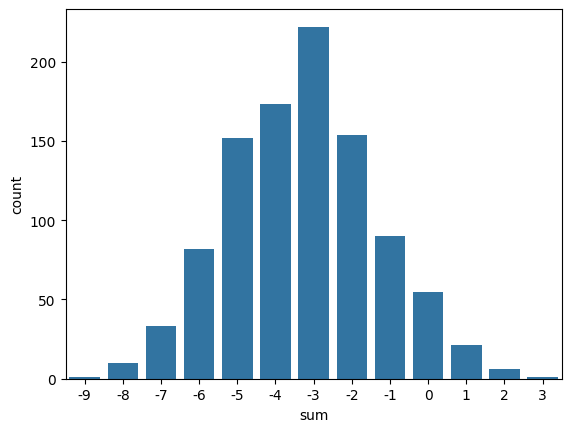

In [10]:
sns.countplot(data=bootstrap, x='sum')

## Evaluation

In [49]:
accuracy_llm = accuracy_score(sampled_df['label'],sampled_df['label_llm'])
f1_llm = f1_score(sampled_df['label'],sampled_df['label_llm'])
accuracy_rag = accuracy_score(sampled_df['label'],sampled_df['label_rag'])
f1_rag = f1_score(sampled_df['label'],sampled_df['label_rag'])

In [51]:
print(f"Baseline Model\nAccuracy: {accuracy_llm:.4f}\nF1 Score: {f1_llm:.4f}\n\nExperimental Model\nAccuracy: {accuracy_rag:.4f}\nF1 Score: {f1_rag:.4f}")

Baseline Model
Accuracy: 0.8460
F1 Score: 0.8432

Experimental Model
Accuracy: 0.5160
F1 Score: 0.5399
